In [1]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim
from torch.autograd import Variable

Using TensorFlow backend.


In [0]:
"""
Here we load the dataset, add gaussian,poisson,speckle

    'gauss'     Gaussian-distributed additive noise.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.
                
We define a function that adds each noise when called from main function
Input & Output: np array
                
"""


def add_noise(img,noise_type="gaussian"):
  
  row,col=28,28
  img=img.astype(np.float32)
  
  if noise_type=="gaussian":
    mean=0
    var=10
    sigma=var**.5
    noise=np.random.normal(-5.9,5.9,img.shape)
    noise=noise.reshape(row,col)
    img=img+noise
    return img

  if noise_type=="speckle":
    noise=np.random.randn(row,col)
    noise=noise.reshape(row,col)
    img=img+img*noise
    return img

In [3]:
#Here we load the dataset from keras
(xtrain,ytrain),(xtest,ytest)=mnist.load_data()
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain),len(xtest)))

11493376/11490434 [==============================] - 4s 0us/step
No of training datapoints:60000
No of Test datapoints:10000


In [10]:
"""
From here onwards,we split the 60k training datapoints into 3 sets each given one type of each noise.
We shuffle them for better generalization.
"""
noises=["gaussian","speckle"]
noise_ct=0
noise_id=0
traindata=np.zeros((60000,28,28))



for idx in tqdm(range(len(xtrain))):
  
  if noise_ct<(len(xtrain)/2):
    noise_ct+=1
    traindata[idx]=add_noise(xtrain[idx],noise_type=noises[noise_id])
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id+=1
    noise_ct=0


print("\n{} noise addition completed to images".format(noises[noise_id])) 




noise_ct=0
noise_id=0
testdata=np.zeros((10000,28,28))

for idx in tqdm(range(len(xtest))):
  
  if noise_ct<(len(xtest)/2):
    noise_ct+=1
    x=add_noise(xtest[idx],noise_type=noises[noise_id])
    testdata[idx]=x
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id+=1
    noise_ct=0


print("\n{} noise addition completed to images".format(noises[noise_id]))    
  

 56%|█████▌    | 33686/60000 [00:01<00:01, 23015.07it/s]


gaussian noise addition completed to images


 22%|██▏       | 2182/10000 [00:00<00:00, 21816.48it/s]


speckle noise addition completed to images


 87%|████████▋ | 8747/10000 [00:00<00:00, 22026.82it/s]


gaussian noise addition completed to images


100%|██████████| 10000/10000 [00:00<00:00, 21813.70it/s]


speckle noise addition completed to images


Text(0.5, 1.0, 'Noised Image')

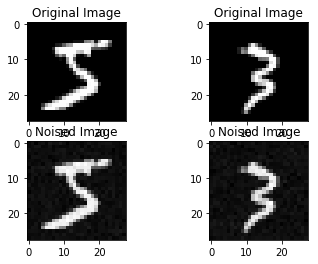

In [11]:
"""
Here we Try to visualize, each type of noise that was introduced in the images
Along with their original versions

"""

f, axes=plt.subplots(2,2)

#showing images with gaussian noise
axes[0,0].imshow(xtrain[0],cmap="gray")
axes[0,0].set_title("Original Image")
axes[1,0].imshow(traindata[0],cmap='gray')
axes[1,0].set_title("Noised Image")

#showing images with speckle noise
axes[0,1].imshow(xtrain[25000],cmap='gray')
axes[0,1].set_title("Original Image")
axes[1,1].imshow(traindata[25000],cmap="gray")
axes[1,1].set_title("Noised Image")



In [0]:
class noisedDataset(Dataset):
  
  def __init__(self,datasetnoised,datasetclean,labels,transform):
    self.noise=datasetnoised
    self.clean=datasetclean
    self.labels=labels
    self.transform=transform
  
  def __len__(self):
    return len(self.noise)
  
  def __getitem__(self,idx):
    xNoise=self.noise[idx]
    xClean=self.clean[idx]
    y=self.labels[idx]
    
    if self.transform != None:
      xNoise=self.transform(xNoise)
      xClean=self.transform(xClean)
      
    
    return (xNoise,xClean,y)
      
  
    

In [0]:
tsfms=transforms.Compose([
    transforms.ToTensor()
])

trainset=noisedDataset(traindata,xtrain,ytrain,tsfms)
testset=noisedDataset(testdata,xtest,ytest,tsfms)

In [0]:
"""
Here , we create the trainloaders and testloaders.
Also, we transform the images using standard lib functions
"""


batch_size=32



trainloader=DataLoader(trainset,batch_size=32,shuffle=True)
testloader=DataLoader(testset,batch_size=1,shuffle=True)



In [0]:
"""
Here, we define the autoencoder model.
"""

class denoising_model(nn.Module):
  def __init__(self):
    super(denoising_model,self).__init__()
    self.encoder=nn.Sequential(
                  nn.Linear(28*28,256),
                  nn.ReLU(True),
                  nn.Linear(256,128),
                  nn.ReLU(True),
                  nn.Linear(128,64),
                  nn.ReLU(True)
        
                  )
    
    self.decoder=nn.Sequential(
                  nn.Linear(64,128),
                  nn.ReLU(True),
                  nn.Linear(128,256),
                  nn.ReLU(True),
                  nn.Linear(256,28*28),
                  nn.Sigmoid(),
                  )
    
 
  def forward(self,x):
    x=self.encoder(x)
    x=self.decoder(x)
    
    return x
  

In [17]:
#We check whether cuda is available and choose device accordingly
if torch.cuda.is_available()==True:
  device="cuda:0"
else:
  device ="cpu"

  
model=denoising_model().to(device)
criterion=nn.MSELoss()
optimizer=optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)


epochs=120
l=len(trainloader)
losslist=list()
epochloss=0
running_loss=0
for epoch in range(epochs):
  
  print("Entering Epoch: ",epoch)
  for dirty,clean,label in tqdm((trainloader)):
    
    
    dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
    clean=clean.view(clean.size(0),-1).type(torch.FloatTensor)
    dirty,clean=dirty.to(device),clean.to(device)
    
    
    
    #-----------------Forward Pass----------------------
    output=model(dirty)
    loss=criterion(output,clean)
    #-----------------Backward Pass---------------------
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    running_loss+=loss.item()
    epochloss+=loss.item()
  #-----------------Log-------------------------------
  losslist.append(running_loss/l)
  running_loss=0
  print("======> epoch: {}/{}, Loss:{}".format(epoch,epochs,loss.item()))
    
    
      
      
    

 

  1%|          | 13/1875 [00:00<00:14, 129.10it/s]

Entering Epoch:  0


  2%|▏         | 32/1875 [00:00<00:05, 318.70it/s]

======> epoch: 0/120, Loss:0.07477772980928421
Entering Epoch:  1


  2%|▏         | 35/1875 [00:00<00:05, 347.27it/s]

======> epoch: 1/120, Loss:0.07071107625961304
Entering Epoch:  2


  2%|▏         | 35/1875 [00:00<00:05, 346.80it/s]

======> epoch: 2/120, Loss:0.0689566433429718
Entering Epoch:  3


  2%|▏         | 30/1875 [00:00<00:06, 293.31it/s]

======> epoch: 3/120, Loss:0.058644551783800125
Entering Epoch:  4


  2%|▏         | 30/1875 [00:00<00:06, 298.86it/s]

======> epoch: 4/120, Loss:0.055324405431747437
Entering Epoch:  5


  2%|▏         | 35/1875 [00:00<00:05, 343.49it/s]

======> epoch: 5/120, Loss:0.06583036482334137
Entering Epoch:  6


  2%|▏         | 36/1875 [00:00<00:05, 352.24it/s]

======> epoch: 6/120, Loss:0.05749344825744629
Entering Epoch:  7


  2%|▏         | 36/1875 [00:00<00:05, 351.48it/s]

======> epoch: 7/120, Loss:0.05596856027841568
Entering Epoch:  8


  2%|▏         | 36/1875 [00:00<00:05, 352.39it/s]

======> epoch: 8/120, Loss:0.05280887708067894
Entering Epoch:  9


  2%|▏         | 36/1875 [00:00<00:05, 351.55it/s]

======> epoch: 9/120, Loss:0.05076480284333229
Entering Epoch:  10


  2%|▏         | 32/1875 [00:00<00:05, 318.82it/s]

======> epoch: 10/120, Loss:0.05066143721342087
Entering Epoch:  11


  2%|▏         | 35/1875 [00:00<00:05, 344.51it/s]

======> epoch: 11/120, Loss:0.04446016624569893
Entering Epoch:  12


  2%|▏         | 35/1875 [00:00<00:05, 345.20it/s]

======> epoch: 12/120, Loss:0.046096790581941605
Entering Epoch:  13


  2%|▏         | 36/1875 [00:00<00:05, 351.29it/s]

======> epoch: 13/120, Loss:0.047888483852148056
Entering Epoch:  14


  2%|▏         | 35/1875 [00:00<00:05, 348.37it/s]

======> epoch: 14/120, Loss:0.04347974434494972
Entering Epoch:  15


  2%|▏         | 35/1875 [00:00<00:05, 343.83it/s]

======> epoch: 15/120, Loss:0.04276827350258827
Entering Epoch:  16


  2%|▏         | 34/1875 [00:00<00:05, 338.63it/s]

======> epoch: 16/120, Loss:0.04144679382443428
Entering Epoch:  17


  2%|▏         | 33/1875 [00:00<00:05, 326.17it/s]

======> epoch: 17/120, Loss:0.03927885368466377
Entering Epoch:  18


  2%|▏         | 31/1875 [00:00<00:06, 300.98it/s]

======> epoch: 18/120, Loss:0.04120118170976639
Entering Epoch:  19


  2%|▏         | 31/1875 [00:00<00:06, 302.35it/s]

======> epoch: 19/120, Loss:0.03607381507754326
Entering Epoch:  20


  2%|▏         | 36/1875 [00:00<00:05, 352.05it/s]

======> epoch: 20/120, Loss:0.04273674264550209
Entering Epoch:  21


  2%|▏         | 36/1875 [00:00<00:05, 350.92it/s]

======> epoch: 21/120, Loss:0.03951810300350189
Entering Epoch:  22


  2%|▏         | 36/1875 [00:00<00:05, 351.67it/s]

======> epoch: 22/120, Loss:0.03777847811579704
Entering Epoch:  23


  2%|▏         | 36/1875 [00:00<00:05, 352.07it/s]

======> epoch: 23/120, Loss:0.03964350000023842
Entering Epoch:  24


  2%|▏         | 33/1875 [00:00<00:05, 327.03it/s]

======> epoch: 24/120, Loss:0.036437053233385086
Entering Epoch:  25


  2%|▏         | 35/1875 [00:00<00:05, 349.34it/s]

======> epoch: 25/120, Loss:0.03277333453297615
Entering Epoch:  26


  2%|▏         | 36/1875 [00:00<00:05, 353.20it/s]

======> epoch: 26/120, Loss:0.03898153826594353
Entering Epoch:  27


  2%|▏         | 36/1875 [00:00<00:05, 352.82it/s]

======> epoch: 27/120, Loss:0.03752512112259865
Entering Epoch:  28


  2%|▏         | 36/1875 [00:00<00:05, 353.56it/s]

======> epoch: 28/120, Loss:0.03705248236656189
Entering Epoch:  29


  2%|▏         | 36/1875 [00:00<00:05, 353.26it/s]

======> epoch: 29/120, Loss:0.032881107181310654
Entering Epoch:  30


  2%|▏         | 33/1875 [00:00<00:05, 325.81it/s]

======> epoch: 30/120, Loss:0.0395297072827816
Entering Epoch:  31


  2%|▏         | 36/1875 [00:00<00:05, 350.38it/s]

======> epoch: 31/120, Loss:0.03000573441386223
Entering Epoch:  32


  2%|▏         | 35/1875 [00:00<00:05, 348.96it/s]

======> epoch: 32/120, Loss:0.03471994772553444
Entering Epoch:  33


  2%|▏         | 29/1875 [00:00<00:06, 281.56it/s]

======> epoch: 33/120, Loss:0.03302660584449768
Entering Epoch:  34


  2%|▏         | 35/1875 [00:00<00:05, 347.95it/s]

======> epoch: 34/120, Loss:0.03391418233513832
Entering Epoch:  35


  2%|▏         | 35/1875 [00:00<00:05, 347.52it/s]

======> epoch: 35/120, Loss:0.0332057848572731
Entering Epoch:  36


  2%|▏         | 35/1875 [00:00<00:05, 344.98it/s]

======> epoch: 36/120, Loss:0.028860732913017273
Entering Epoch:  37


  2%|▏         | 29/1875 [00:00<00:06, 288.09it/s]

======> epoch: 37/120, Loss:0.03008740209043026
Entering Epoch:  38


  2%|▏         | 30/1875 [00:00<00:06, 291.37it/s]

======> epoch: 38/120, Loss:0.03580300137400627
Entering Epoch:  39


  2%|▏         | 36/1875 [00:00<00:05, 353.25it/s]

======> epoch: 39/120, Loss:0.029674720019102097
Entering Epoch:  40


  2%|▏         | 35/1875 [00:00<00:05, 345.04it/s]

======> epoch: 40/120, Loss:0.03466292470693588
Entering Epoch:  41


  2%|▏         | 35/1875 [00:00<00:05, 347.94it/s]

======> epoch: 41/120, Loss:0.029113681986927986
Entering Epoch:  42


  2%|▏         | 33/1875 [00:00<00:05, 323.87it/s]

======> epoch: 42/120, Loss:0.032162293791770935
Entering Epoch:  43


  2%|▏         | 35/1875 [00:00<00:05, 349.81it/s]

======> epoch: 43/120, Loss:0.02975574880838394
Entering Epoch:  44


  2%|▏         | 36/1875 [00:00<00:05, 355.19it/s]

======> epoch: 44/120, Loss:0.0300697460770607
Entering Epoch:  45


  2%|▏         | 33/1875 [00:00<00:05, 321.71it/s]

======> epoch: 45/120, Loss:0.035581495612859726
Entering Epoch:  46


  2%|▏         | 36/1875 [00:00<00:05, 350.47it/s]

======> epoch: 46/120, Loss:0.03387004882097244
Entering Epoch:  47


  2%|▏         | 30/1875 [00:00<00:06, 298.18it/s]

======> epoch: 47/120, Loss:0.0324636809527874
Entering Epoch:  48


  2%|▏         | 31/1875 [00:00<00:06, 302.94it/s]

======> epoch: 48/120, Loss:0.02689267508685589
Entering Epoch:  49


  2%|▏         | 35/1875 [00:00<00:05, 348.00it/s]

======> epoch: 49/120, Loss:0.033404625952243805
Entering Epoch:  50


  2%|▏         | 36/1875 [00:00<00:05, 351.66it/s]

======> epoch: 50/120, Loss:0.026478808373212814
Entering Epoch:  51


  2%|▏         | 36/1875 [00:00<00:05, 351.06it/s]

======> epoch: 51/120, Loss:0.02790663205087185
Entering Epoch:  52


  2%|▏         | 35/1875 [00:00<00:05, 341.16it/s]

======> epoch: 52/120, Loss:0.027032755315303802
Entering Epoch:  53


  2%|▏         | 35/1875 [00:00<00:05, 348.26it/s]

======> epoch: 53/120, Loss:0.027010425925254822
Entering Epoch:  54


  2%|▏         | 34/1875 [00:00<00:05, 337.82it/s]

======> epoch: 54/120, Loss:0.029131080955266953
Entering Epoch:  55


  2%|▏         | 35/1875 [00:00<00:05, 340.86it/s]

======> epoch: 55/120, Loss:0.028712039813399315
Entering Epoch:  56


  2%|▏         | 35/1875 [00:00<00:05, 349.73it/s]

======> epoch: 56/120, Loss:0.03216388821601868
Entering Epoch:  57


  2%|▏         | 36/1875 [00:00<00:05, 354.40it/s]

======> epoch: 57/120, Loss:0.027881227433681488
Entering Epoch:  58


  2%|▏         | 32/1875 [00:00<00:05, 317.00it/s]

======> epoch: 58/120, Loss:0.03054805099964142
Entering Epoch:  59


  2%|▏         | 36/1875 [00:00<00:05, 352.31it/s]

======> epoch: 59/120, Loss:0.027852550148963928
Entering Epoch:  60


  2%|▏         | 33/1875 [00:00<00:05, 328.34it/s]

======> epoch: 60/120, Loss:0.028727371245622635
Entering Epoch:  61


  2%|▏         | 36/1875 [00:00<00:05, 351.81it/s]

======> epoch: 61/120, Loss:0.03103669360280037
Entering Epoch:  62


  2%|▏         | 30/1875 [00:00<00:06, 296.59it/s]

======> epoch: 62/120, Loss:0.028559764847159386
Entering Epoch:  63


  2%|▏         | 31/1875 [00:00<00:06, 302.23it/s]

======> epoch: 63/120, Loss:0.027164896950125694
Entering Epoch:  64


  2%|▏         | 35/1875 [00:00<00:05, 349.63it/s]

======> epoch: 64/120, Loss:0.02717626839876175
Entering Epoch:  65


  2%|▏         | 36/1875 [00:00<00:05, 355.14it/s]

======> epoch: 65/120, Loss:0.025673391297459602
Entering Epoch:  66


  2%|▏         | 36/1875 [00:00<00:05, 350.95it/s]

======> epoch: 66/120, Loss:0.02766711451113224
Entering Epoch:  67


  2%|▏         | 36/1875 [00:00<00:05, 352.20it/s]

======> epoch: 67/120, Loss:0.03018694929778576
Entering Epoch:  68


  2%|▏         | 33/1875 [00:00<00:05, 325.92it/s]

======> epoch: 68/120, Loss:0.024607863277196884
Entering Epoch:  69


  2%|▏         | 35/1875 [00:00<00:05, 346.91it/s]

======> epoch: 69/120, Loss:0.02705385535955429
Entering Epoch:  70


  2%|▏         | 36/1875 [00:00<00:05, 352.84it/s]

======> epoch: 70/120, Loss:0.026117105036973953
Entering Epoch:  71


  2%|▏         | 36/1875 [00:00<00:05, 353.61it/s]

======> epoch: 71/120, Loss:0.02892029844224453
Entering Epoch:  72


  2%|▏         | 35/1875 [00:00<00:05, 349.92it/s]

======> epoch: 72/120, Loss:0.027028189972043037
Entering Epoch:  73


  2%|▏         | 36/1875 [00:00<00:05, 351.17it/s]

======> epoch: 73/120, Loss:0.028847752138972282
Entering Epoch:  74


  2%|▏         | 34/1875 [00:00<00:05, 339.54it/s]

======> epoch: 74/120, Loss:0.027272889390587807
Entering Epoch:  75


  2%|▏         | 35/1875 [00:00<00:05, 345.00it/s]

======> epoch: 75/120, Loss:0.02643396332859993
Entering Epoch:  76


  2%|▏         | 36/1875 [00:00<00:05, 352.26it/s]

======> epoch: 76/120, Loss:0.02690323442220688
Entering Epoch:  77


  2%|▏         | 30/1875 [00:00<00:06, 296.00it/s]

======> epoch: 77/120, Loss:0.026185598224401474
Entering Epoch:  78


  2%|▏         | 31/1875 [00:00<00:06, 304.29it/s]

======> epoch: 78/120, Loss:0.027222611010074615
Entering Epoch:  79


  2%|▏         | 34/1875 [00:00<00:05, 339.66it/s]

======> epoch: 79/120, Loss:0.02516557276248932
Entering Epoch:  80


  2%|▏         | 36/1875 [00:00<00:05, 352.42it/s]

======> epoch: 80/120, Loss:0.024410229176282883
Entering Epoch:  81


  2%|▏         | 36/1875 [00:00<00:05, 352.60it/s]

======> epoch: 81/120, Loss:0.03344433382153511
Entering Epoch:  82


  2%|▏         | 35/1875 [00:00<00:05, 349.00it/s]

======> epoch: 82/120, Loss:0.02569134160876274
Entering Epoch:  83


  2%|▏         | 35/1875 [00:00<00:05, 344.56it/s]

======> epoch: 83/120, Loss:0.02614513225853443
Entering Epoch:  84


  2%|▏         | 36/1875 [00:00<00:05, 351.39it/s]

======> epoch: 84/120, Loss:0.02682308480143547
Entering Epoch:  85


  2%|▏         | 36/1875 [00:00<00:05, 353.77it/s]

======> epoch: 85/120, Loss:0.027318723499774933
Entering Epoch:  86


  2%|▏         | 36/1875 [00:00<00:05, 353.14it/s]

======> epoch: 86/120, Loss:0.022243259474635124
Entering Epoch:  87


  2%|▏         | 35/1875 [00:00<00:05, 346.17it/s]

======> epoch: 87/120, Loss:0.0257416944950819
Entering Epoch:  88


  2%|▏         | 35/1875 [00:00<00:05, 349.07it/s]

======> epoch: 88/120, Loss:0.025301240384578705
Entering Epoch:  89


  2%|▏         | 35/1875 [00:00<00:05, 349.60it/s]

======> epoch: 89/120, Loss:0.02317321114242077
Entering Epoch:  90


  2%|▏         | 35/1875 [00:00<00:05, 346.95it/s]

======> epoch: 90/120, Loss:0.026089739054441452
Entering Epoch:  91


  2%|▏         | 32/1875 [00:00<00:05, 316.74it/s]

======> epoch: 91/120, Loss:0.02275414764881134
Entering Epoch:  92


  2%|▏         | 30/1875 [00:00<00:06, 296.32it/s]

======> epoch: 92/120, Loss:0.02440083585679531
Entering Epoch:  93


  2%|▏         | 31/1875 [00:00<00:06, 301.27it/s]

======> epoch: 93/120, Loss:0.02597312070429325
Entering Epoch:  94


  1%|▏         | 27/1875 [00:00<00:06, 267.94it/s]

======> epoch: 94/120, Loss:0.027220115065574646
Entering Epoch:  95


  2%|▏         | 30/1875 [00:00<00:06, 293.62it/s]

======> epoch: 95/120, Loss:0.023383814841508865
Entering Epoch:  96


  2%|▏         | 32/1875 [00:00<00:05, 317.33it/s]

======> epoch: 96/120, Loss:0.02564122900366783
Entering Epoch:  97


  2%|▏         | 36/1875 [00:00<00:05, 350.38it/s]

======> epoch: 97/120, Loss:0.027132095769047737
Entering Epoch:  98


  2%|▏         | 35/1875 [00:00<00:05, 344.54it/s]

======> epoch: 98/120, Loss:0.02385694719851017
Entering Epoch:  99


  2%|▏         | 36/1875 [00:00<00:05, 353.86it/s]

======> epoch: 99/120, Loss:0.023021945729851723
Entering Epoch:  100


  2%|▏         | 36/1875 [00:00<00:05, 353.66it/s]

======> epoch: 100/120, Loss:0.025326967239379883
Entering Epoch:  101


  2%|▏         | 35/1875 [00:00<00:05, 347.86it/s]

======> epoch: 101/120, Loss:0.022845067083835602
Entering Epoch:  102


  2%|▏         | 33/1875 [00:00<00:05, 324.68it/s]

======> epoch: 102/120, Loss:0.02455546334385872
Entering Epoch:  103


  2%|▏         | 35/1875 [00:00<00:05, 345.44it/s]

======> epoch: 103/120, Loss:0.023210963234305382
Entering Epoch:  104


  2%|▏         | 35/1875 [00:00<00:05, 349.62it/s]

======> epoch: 104/120, Loss:0.02328934520483017
Entering Epoch:  105


  2%|▏         | 36/1875 [00:00<00:05, 352.44it/s]

======> epoch: 105/120, Loss:0.02464912086725235
Entering Epoch:  106


  2%|▏         | 36/1875 [00:00<00:05, 351.26it/s]

======> epoch: 106/120, Loss:0.027664480730891228
Entering Epoch:  107


  2%|▏         | 31/1875 [00:00<00:06, 303.27it/s]

======> epoch: 107/120, Loss:0.023136386647820473
Entering Epoch:  108


  2%|▏         | 31/1875 [00:00<00:06, 301.45it/s]

======> epoch: 108/120, Loss:0.024768907576799393
Entering Epoch:  109


  2%|▏         | 36/1875 [00:00<00:05, 352.92it/s]

======> epoch: 109/120, Loss:0.02430102601647377
Entering Epoch:  110


  2%|▏         | 36/1875 [00:00<00:05, 353.99it/s]

======> epoch: 110/120, Loss:0.023662012070417404
Entering Epoch:  111


  2%|▏         | 35/1875 [00:00<00:05, 345.46it/s]

======> epoch: 111/120, Loss:0.021156126633286476
Entering Epoch:  112


  2%|▏         | 36/1875 [00:00<00:05, 353.20it/s]

======> epoch: 112/120, Loss:0.024805745109915733
Entering Epoch:  113


  2%|▏         | 36/1875 [00:00<00:05, 351.21it/s]

======> epoch: 113/120, Loss:0.022023756057024002
Entering Epoch:  114


  2%|▏         | 35/1875 [00:00<00:05, 349.02it/s]

======> epoch: 114/120, Loss:0.022249484434723854
Entering Epoch:  115


  2%|▏         | 35/1875 [00:00<00:05, 347.03it/s]

======> epoch: 115/120, Loss:0.025139397010207176
Entering Epoch:  116


  2%|▏         | 35/1875 [00:00<00:05, 348.38it/s]

======> epoch: 116/120, Loss:0.024218140169978142
Entering Epoch:  117


  2%|▏         | 35/1875 [00:00<00:05, 347.97it/s]

======> epoch: 117/120, Loss:0.02438724786043167
Entering Epoch:  118


  2%|▏         | 36/1875 [00:00<00:05, 352.38it/s]

======> epoch: 118/120, Loss:0.024126427248120308
Entering Epoch:  119


100%|██████████| 1875/1875 [00:05<00:00, 354.11it/s]

======> epoch: 119/120, Loss:0.02400180697441101


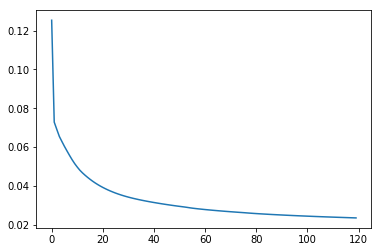

In [20]:
plt.plot(range(len(losslist)),losslist)

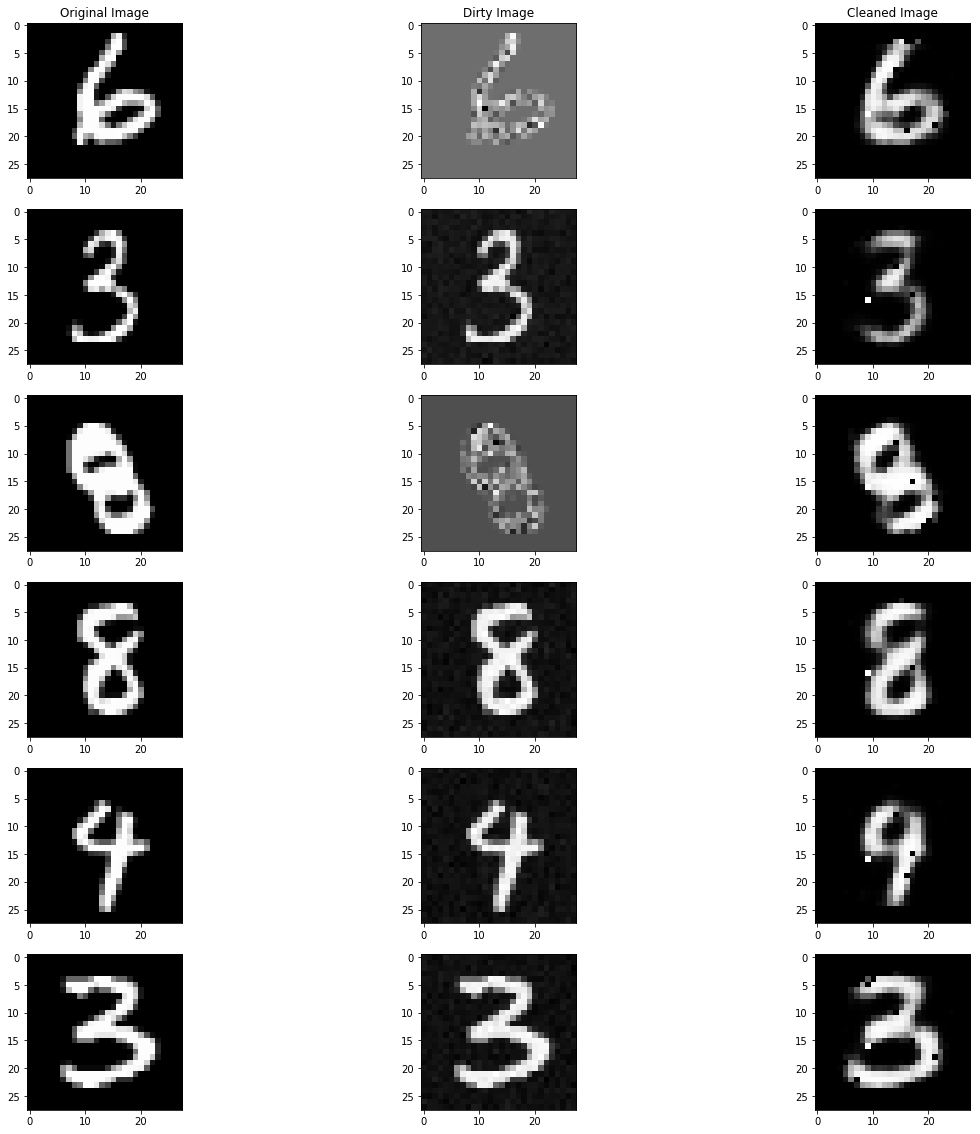

In [67]:
"""Here, we try to visualize some of the results.
  We randomly generate 6 numbers in between 1 and 10k , run them through the model,
  and show the results with comparisons
  
 """




f,axes= plt.subplots(6,3,figsize=(20,20))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")

test_imgs=np.random.randint(0,10000,size=6)
for idx in range((6)):
  dirty=testset[test_imgs[idx]][0]
  clean=testset[test_imgs[idx]][1]
  label=testset[test_imgs[idx]][2]
  dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
  dirty=dirty.to(device)
  output=model(dirty)
  
  output=output.view(1,28,28)
  output=output.permute(1,2,0).squeeze(2)
  output=output.detach().cpu().numpy()
  
  dirty=dirty.view(1,28,28)
  dirty=dirty.permute(1,2,0).squeeze(2)
  dirty=dirty.detach().cpu().numpy()
  
  clean=clean.permute(1,2,0).squeeze(2)
  clean=clean.detach().cpu().numpy()
  
  axes[idx,0].imshow(clean,cmap="gray")
  axes[idx,1].imshow(dirty,cmap="gray")
  axes[idx,2].imshow(output,cmap="gray")
  


  
  
  
  

In [0]:
PATH=""
torch.save(model.state_dict(),PATH)  # We save the model state dict at PATH   